# Layer Normalization

In [1]:
import torch

import triton
import triton.language as tl

In [2]:
try:
    import apex
    HAS_APEX = True
except ModuleNotFoundError:
    HAS_APEX = False

In [3]:
DEVICE = torch.device("cuda:0")

In [4]:
@triton.jit
def _layer_norm_fwd_fused(
    X,  # pointer to the input
    Y,  # pointer to the output
    W,  # pointer to the weights
    B,  # pointer to the biases
    Mean,  # pointer to the mean
    Rstd,  # pointer to the 1/std
    stride,  # how much to increase the pointer when moving by 1 row
    N,  # number of columns in X
    eps,  # epsilon to avoid division by zero
    BLOCK_SIZE: tl.constexpr,
):
    # Map the program id to the row of X and Y it should compute.
    row = tl.program_id(0)
    Y += row * stride
    X += row * stride
    # Compute mean
    mean = 0
    _mean = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    for off in range(0, N, BLOCK_SIZE):
        cols = off + tl.arange(0, BLOCK_SIZE)
        a = tl.load(X + cols, mask=cols < N, other=0.).to(tl.float32)
        _mean += a
    mean = tl.sum(_mean, axis=0) / N
    # Compute variance
    _var = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    for off in range(0, N, BLOCK_SIZE):
        cols = off + tl.arange(0, BLOCK_SIZE)
        x = tl.load(X + cols, mask=cols < N, other=0.).to(tl.float32)
        x = tl.where(cols < N, x - mean, 0.)
        _var += x * x
    var = tl.sum(_var, axis=0) / N
    rstd = 1 / tl.sqrt(var + eps)
    # Write mean / rstd
    tl.store(Mean + row, mean)
    tl.store(Rstd + row, rstd)
    # Normalize and apply linear transformation
    for off in range(0, N, BLOCK_SIZE):
        cols = off + tl.arange(0, BLOCK_SIZE)
        mask = cols < N
        w = tl.load(W + cols, mask=mask)
        b = tl.load(B + cols, mask=mask)
        x = tl.load(X + cols, mask=mask, other=0.).to(tl.float32)
        x_hat = (x - mean) * rstd
        y = x_hat * w + b
        # Write output
        tl.store(Y + cols, y, mask=mask)

In [5]:
@triton.jit
def _layer_norm_bwd_dx_fused(DX,  # pointer to the input gradient
                             DY,  # pointer to the output gradient
                             DW,  # pointer to the partial sum of weights gradient
                             DB,  # pointer to the partial sum of biases gradient
                             X,  # pointer to the input
                             W,  # pointer to the weights
                             Mean,  # pointer to the mean
                             Rstd,  # pointer to the 1/std
                             Lock,  # pointer to the lock
                             stride,  # how much to increase the pointer when moving by 1 row
                             N,  # number of columns in X
                             GROUP_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr):
    # Map the program id to the elements of X, DX, and DY it should compute.
    row = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE_N)
    mask = cols < N
    X += row * stride
    DY += row * stride
    DX += row * stride
    # Offset locks and weights/biases gradient pointer for parallel reduction
    lock_id = row % GROUP_SIZE_M
    Lock += lock_id
    Count = Lock + GROUP_SIZE_M
    DW = DW + lock_id * N + cols
    DB = DB + lock_id * N + cols
    # Load data to SRAM
    x = tl.load(X + cols, mask=mask, other=0).to(tl.float32)
    dy = tl.load(DY + cols, mask=mask, other=0).to(tl.float32)
    w = tl.load(W + cols, mask=mask).to(tl.float32)
    mean = tl.load(Mean + row)
    rstd = tl.load(Rstd + row)
    # Compute dx
    xhat = (x - mean) * rstd
    wdy = w * dy
    xhat = tl.where(mask, xhat, 0.)
    wdy = tl.where(mask, wdy, 0.)
    c1 = tl.sum(xhat * wdy, axis=0) / N
    c2 = tl.sum(wdy, axis=0) / N
    dx = (wdy - (xhat * c1 + c2)) * rstd
    # Write dx
    tl.store(DX + cols, dx, mask=mask)
    # Accumulate partial sums for dw/db
    partial_dw = (dy * xhat).to(w.dtype)
    partial_db = (dy).to(w.dtype)
    while tl.atomic_cas(Lock, 0, 1) == 1:
        pass
    count = tl.load(Count)
    # First store doesn't accumulate
    if count == 0:
        tl.atomic_xchg(Count, 1)
    else:
        partial_dw += tl.load(DW, mask=mask)
        partial_db += tl.load(DB, mask=mask)
    tl.store(DW, partial_dw, mask=mask)
    tl.store(DB, partial_db, mask=mask)
    # Release the lock
    tl.atomic_xchg(Lock, 0)

In [6]:
@triton.jit
def _layer_norm_bwd_dwdb(DW,  # pointer to the partial sum of weights gradient
                         DB,  # pointer to the partial sum of biases gradient
                         FINAL_DW,  # pointer to the weights gradient
                         FINAL_DB,  # pointer to the biases gradient
                         M,  # GROUP_SIZE_M
                         N,  # number of columns
                         BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr):
    # Map the program id to the elements of DW and DB it should compute.
    pid = tl.program_id(0)
    cols = pid * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    dw = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    db = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    # Iterate through the rows of DW and DB to sum the partial sums.
    for i in range(0, M, BLOCK_SIZE_M):
        rows = i + tl.arange(0, BLOCK_SIZE_M)
        mask = (rows[:, None] < M) & (cols[None, :] < N)
        offs = rows[:, None] * N + cols[None, :]
        dw += tl.load(DW + offs, mask=mask, other=0.)
        db += tl.load(DB + offs, mask=mask, other=0.)
    # Write the final sum to the output.
    sum_dw = tl.sum(dw, axis=0)
    sum_db = tl.sum(db, axis=0)
    tl.store(FINAL_DW + cols, sum_dw, mask=cols < N)
    tl.store(FINAL_DB + cols, sum_db, mask=cols < N)

## Benchmark

In [7]:
class LayerNorm(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, normalized_shape, weight, bias, eps):
        # allocate output
        y = torch.empty_like(x)
        # reshape input data into 2D tensor
        x_arg = x.reshape(-1, x.shape[-1])
        M, N = x_arg.shape
        mean = torch.empty((M, ), dtype=torch.float32, device=x.device)
        rstd = torch.empty((M, ), dtype=torch.float32, device=x.device)
        # Less than 64KB per feature: enqueue fused kernel
        MAX_FUSED_SIZE = 65536 // x.element_size()
        BLOCK_SIZE = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
        if N > BLOCK_SIZE:
            raise RuntimeError("This layer norm doesn't support feature dim >= 64KB.")
        # heuristics for number of warps
        num_warps = min(max(BLOCK_SIZE // 256, 1), 8)
        # enqueue kernel
        _layer_norm_fwd_fused[(M, )](  #
            x_arg, y, weight, bias, mean, rstd,  #
            x_arg.stride(0), N, eps,  #
            BLOCK_SIZE=BLOCK_SIZE, num_warps=num_warps, num_ctas=1)
        ctx.save_for_backward(x, weight, bias, mean, rstd)
        ctx.BLOCK_SIZE = BLOCK_SIZE
        ctx.num_warps = num_warps
        ctx.eps = eps
        return y

    @staticmethod
    def backward(ctx, dy):
        x, w, b, m, v = ctx.saved_tensors
        # heuristics for amount of parallel reduction stream for DW/DB
        N = w.shape[0]
        GROUP_SIZE_M = 64
        if N <= 8192: GROUP_SIZE_M = 96
        if N <= 4096: GROUP_SIZE_M = 128
        if N <= 1024: GROUP_SIZE_M = 256
        # allocate output
        locks = torch.zeros(2 * GROUP_SIZE_M, dtype=torch.int32, device=w.device)
        _dw = torch.zeros((GROUP_SIZE_M, N), dtype=x.dtype, device=w.device)
        _db = torch.zeros((GROUP_SIZE_M, N), dtype=x.dtype, device=w.device)
        dw = torch.empty((N, ), dtype=w.dtype, device=w.device)
        db = torch.empty((N, ), dtype=w.dtype, device=w.device)
        dx = torch.empty_like(dy)
        # enqueue kernel using forward pass heuristics
        # also compute partial sums for DW and DB
        x_arg = x.reshape(-1, x.shape[-1])
        M, N = x_arg.shape
        _layer_norm_bwd_dx_fused[(M, )](  #
            dx, dy, _dw, _db, x, w, m, v, locks,  #
            x_arg.stride(0), N,  #
            BLOCK_SIZE_N=ctx.BLOCK_SIZE,  #
            GROUP_SIZE_M=GROUP_SIZE_M,  #
            num_warps=ctx.num_warps)
        grid = lambda meta: [triton.cdiv(N, meta['BLOCK_SIZE_N'])]
        # accumulate partial sums in separate kernel
        _layer_norm_bwd_dwdb[grid](
            _dw, _db, dw, db, min(GROUP_SIZE_M, M), N,  #
            BLOCK_SIZE_M=32,  #
            BLOCK_SIZE_N=128, num_ctas=1)
        return dx, None, dw, db, None


layer_norm = LayerNorm.apply

In [8]:
def test_layer_norm(M, N, dtype, eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    # forward pass
    y_tri = layer_norm(x, w_shape, weight, bias, eps)
    y_ref = torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps).to(dtype)
    # backward pass (triton)
    y_tri.backward(dy, retain_graph=True)
    dx_tri, dw_tri, db_tri = [_.grad.clone() for _ in [x, weight, bias]]
    x.grad, weight.grad, bias.grad = None, None, None
    # backward pass (torch)
    y_ref.backward(dy, retain_graph=True)
    dx_ref, dw_ref, db_ref = [_.grad.clone() for _ in [x, weight, bias]]
    # compare
    assert torch.allclose(y_tri, y_ref, atol=1e-2, rtol=0)
    assert torch.allclose(dx_tri, dx_ref, atol=1e-2, rtol=0)
    assert torch.allclose(db_tri, db_ref, atol=1e-2, rtol=0)
    assert torch.allclose(dw_tri, dw_ref, atol=1e-2, rtol=0)

layer-norm-backward:
          N      Triton       Torch
0    1024.0  192.000000  130.723400
1    1536.0  219.306182  122.003099
2    2048.0  223.418180  119.373408
3    2560.0  203.643905  111.893458
4    3072.0  175.373222  103.609675
5    3584.0  148.704046   98.568023
6    4096.0  128.412783  101.331269
7    4608.0  157.545479   98.391464
8    5120.0  134.059281   98.291717
9    5632.0  116.700191   98.232558
10   6144.0  106.789300   98.332679
11   6656.0  103.066881   97.049820
12   7168.0  101.673761   95.514464
13   7680.0  100.969595   93.280829
14   8192.0  100.449539  100.496066
15   8704.0  114.614681   93.907601
16   9216.0  108.689932   94.450549
17   9728.0  105.141669   95.613609
18  10240.0  103.608773   96.378236
19  10752.0  102.726113   95.639747
20  11264.0  102.399997   94.341135
21  11776.0  102.089066   95.610287
22  12288.0  101.996047   95.616289
23  12800.0  101.983041   91.469404
24  13312.0  101.811104   93.418397
25  13824.0  101.754224   92.025795
26  143

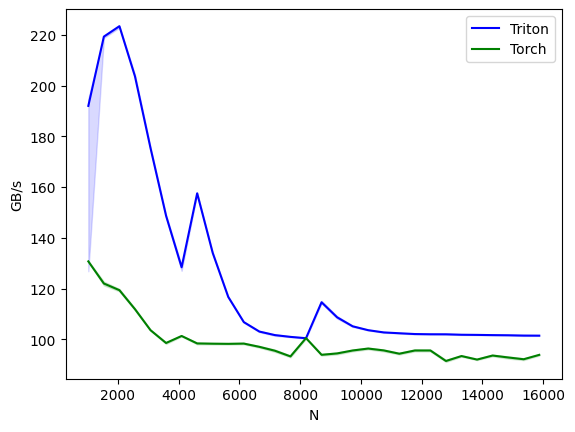

In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[512 * i for i in range(2, 32)],
        line_arg='provider',
        line_vals=['triton', 'torch'] + (['apex'] if HAS_APEX else []),
        line_names=['Triton', 'Torch'] + (['Apex'] if HAS_APEX else []),
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],
        ylabel='GB/s',
        plot_name='layer-norm-backward',
        args={'M': 4096, 'dtype': torch.float16, 'mode': 'backward'},
    ))
def bench_layer_norm(M, N, dtype, provider, mode='backward', eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():

        if provider == "triton":
            return layer_norm(x, w_shape, weight, bias, eps)  # noqa: F811, E704

        if provider == "torch":
            return torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps)  # noqa: F811, E704

        if provider == "apex":
            apex_layer_norm = (apex.normalization.FusedLayerNorm(w_shape).to(x.device).to(x.dtype))
            return apex_layer_norm(x)  # noqa: F811, E704

    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    # backward pass
    if mode == 'backward':
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)  # noqa: F811, E704
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), quantiles=quantiles,
                                                     grad_to_none=[x], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


test_layer_norm(1151, 8192, torch.float16)
bench_layer_norm.run(save_path='.', print_data=True)